## Importing all the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
import lxml
import html5lib
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

print('Packages installed  :)')

Packages installed  :)


## Getting the data using BeautifulSoup 

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content,'lxml')

In [3]:
temp = BeautifulSoup(str(data_html),'lxml')
t = temp.find('table')
t = str(t.extract())

## Reading the data into a pandas dataframe

In [4]:
df = pd.read_html(t)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## Removing boroughs that are not assigned

In [5]:
df.drop(df.index[df['Borough'] == 'Not assigned'], inplace=True)
df = df.reset_index(drop=True)

In [6]:
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## Grouping the data based on boroughs

In [7]:
df= df.groupby(['Borough', 'Postal Code'], as_index=False).agg(lambda x:','.join(x))
df.head()

,Borough,Postal Code,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


## Rearranging the columns for better readability

In [8]:
df = df[['Postal Code', 'Borough', 'Neighbourhood']]
df

,Postal Code,Borough,Neighbourhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"
...,...,...,...
98,M6C,York,Humewood-Cedarvale
99,M6E,York,Caledonia-Fairbanks
100,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn"
101,M6N,York,"Runnymede, The Junction North"


## Getting the latitudes adn longitudes for different postal codes

In [9]:
geo_url = "https://cocl.us/Geospatial_data"
geo_df = pd.read_csv(geo_url)
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging the two data frames

In [10]:
df = pd.merge(df, geo_df, on='Postal Code')
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


## All neighbourhoods with toronto in it

In [11]:
df_toronto = df
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [12]:
boroughs = df_toronto['Borough'].unique().tolist()

In [13]:
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.704607733980595, -79.3971529116505


In [14]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

In [15]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill=True,
        fill_color=borough_color[borough],
        fill_opacity=0.8,parse_html=False).add_to(map_toronto)  
    
map_toronto

## Define Foursquare credentials

In [16]:
CLIENT_ID = 'BMZ0MDUIQXVG0KERJVVRN3JDZYGULNVK4OWUGBAMUVIEJLX2' # your Foursquare ID
CLIENT_SECRET = '2APD0HAYZCMEGOOCCRMNJVMENPNF3GVB44MY21U3HK2U40RF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BMZ0MDUIQXVG0KERJVVRN3JDZYGULNVK4OWUGBAMUVIEJLX2
CLIENT_SECRET:2APD0HAYZCMEGOOCCRMNJVMENPNF3GVB44MY21U3HK2U40RF


## Top 100 venues

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [19]:
print(toronto_venues.shape)
toronto_venues.head()

(2098, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


Number of venues per neighbourhood

In [20]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
"Willowdale, Willowdale East",33,33,33,33,33,33
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4


## Unique Categories

In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 270 uniques categories.


In [22]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
toronto_onehot.shape

(2098, 271)

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.000,0.030303,0.0,0.0,0.0,0.0,0.0,0.0
93,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
94,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
95,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Top 5 venues

In [25]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Breakfast Spot   0.2
1                     Lounge   0.2
2             Clothing Store   0.2
3               Skating Rink   0.2
4  Latin American Restaurant   0.2


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.33
1                 Gym  0.17
2                 Pub  0.17
3         Coffee Shop  0.17
4  Athletics & Sports  0.17


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                       Bank  0.09
1                Coffee Shop  0.09
2                  Pet Store  0.05
3                 Restaurant  0.05
4  Middle Eastern Restaurant  0.05


----Bayview Village----
                       venue  freq
0        Japanese Restaurant  0.25
1         Chinese Restaurant  0.25
2                       Bank  0.25
3                       Café  0.25
4  Middle Eastern Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                     ve

## Top 10 Common venues

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Clothing Store,Latin American Restaurant,Skating Rink,Yoga Studio,Doner Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Athletics & Sports,Pub,Gym,Eastern European Restaurant,Electronics Store,Dumpling Restaurant,Drugstore,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pet Store,Frozen Yogurt Shop,Bridal Shop,Shopping Mall,Diner,Sandwich Place,Deli / Bodega,Middle Eastern Restaurant
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Restaurant,Sushi Restaurant,Café,Indian Restaurant,Japanese Restaurant,Pub,Juice Bar


In [28]:
it = toronto_grouped[["Neighbourhood","Italian Restaurant"]]
it.head()

,Neighbourhood,Italian Restaurant
0,Agincourt,0.00
1,"Alderwood, Long Branch",0.00
2,"Bathurst Manor, Wilson Heights, Downsview North",0.00
3,Bayview Village,0.00
4,"Bedford Park, Lawrence Manor East",0.12


## Kmeans Clustering

Best K is found by using Elbow method

In [29]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = it.drop(['Neighbourhood'], axis=1)

In [30]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 0, 0, 2, 0, 0], dtype=int32)

In [31]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [32]:
scores = [get_inertia(x) for x in range(2, 21)]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Error')

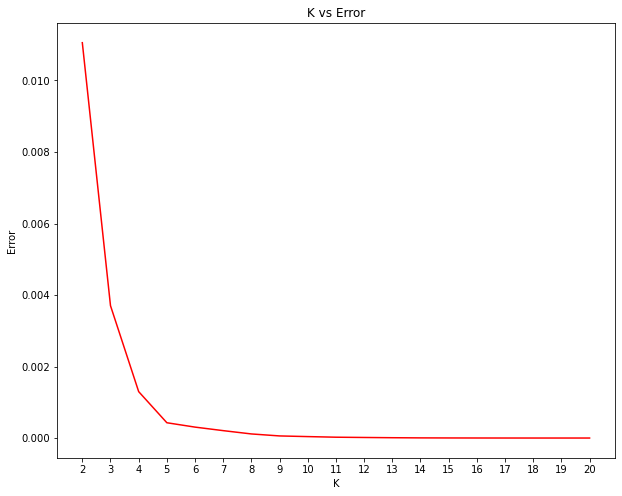

In [33]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [34]:
from yellowbrick.cluster import KElbowVisualizer

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


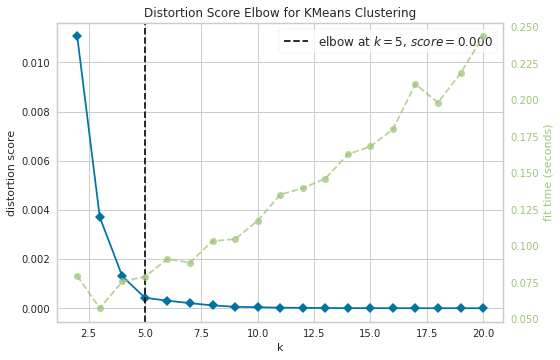

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))
visualizer.fit(X)# Fit the data to the visualizer
visualizer.show()

We can see that best value of k is 5

In [36]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = it.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 0, 0, 1, 0, 0], dtype=int32)

In [37]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = it.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_venues.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Neighbourhood,Italian Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.7942,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.7942,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.7942,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.7942,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
0,Agincourt,0.0,0,43.7942,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink


In [38]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighbourhood Latitude'], toronto_merged['Neighbourhood Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analysis of clusters

## Cluster 1

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0.0,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,0.0,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,0.0,Twilight,43.791999,-79.258584,Lounge
0,0.0,Mark's,43.791179,-79.259714,Clothing Store
0,0.0,Commander Arena,43.794867,-79.267989,Skating Rink
...,...,...,...,...,...
95,0.0,East York Memorial Arena,43.697624,-79.315145,Athletics & Sports
95,0.0,New Star Video,43.692565,-79.315937,Video Store
96,0.0,Kitchen Food Fair,43.751298,-79.401393,Convenience Store
96,0.0,Tournament Park,43.751257,-79.399717,Park


## Cluster 2

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
7,0.043478,Reebok Crossfit Liberty Village,43.637036,-79.424802,Gym
7,0.043478,Starbucks,43.639090,-79.427622,Coffee Shop
7,0.043478,Pharmacy,43.638090,-79.431810,Bar
7,0.043478,Louie Craft Coffee,43.639284,-79.425620,Coffee Shop
7,0.043478,Caffino,43.639021,-79.425289,Italian Restaurant
...,...,...,...,...,...
74,0.045455,Matt's No Frills,43.663515,-79.367166,Grocery Store
74,0.045455,Cabbage Town Organics,43.664704,-79.368115,Gourmet Shop
74,0.045455,Park Snacks,43.666979,-79.363115,Snack Place
74,0.045455,Corner Convenience,43.664234,-79.368112,Convenience Store


In [41]:
## Cluster 3

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
4,0.12,Aroma Espresso Bar,43.735975,-79.420391,Café
4,0.12,Darbar Persian Grill,43.735484,-79.420006,Restaurant
4,0.12,The Copper Chimney,43.736195,-79.420271,Indian Restaurant
4,0.12,Francobollo,43.734557,-79.419549,Italian Restaurant
4,0.12,Sakura Garden,43.733398,-79.419491,Sushi Restaurant
4,0.12,Pheasant & Firkin,43.735173,-79.419702,Pub
4,0.12,Satay on the Road,43.735310,-79.419783,Thai Restaurant
4,0.12,Freshii,43.731582,-79.419109,Juice Bar
4,0.12,Drums N Flats,43.735035,-79.420040,Comfort Food Restaurant
4,0.12,Karbouzi Greek Taverna,43.736204,-79.420359,Greek Restaurant


In [43]:
## Cluster 4

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
31,0.030000,UNIQLO ユニクロ,43.655910,-79.380641,Clothing Store
31,0.030000,Blaze Pizza,43.656518,-79.380015,Pizza Place
31,0.030000,Burrito Boyz,43.656265,-79.378343,Burrito Place
31,0.030000,Silver Snail Comics,43.657031,-79.381403,Comic Shop
31,0.030000,Page One Cafe,43.657772,-79.376073,Café
...,...,...,...,...,...
85,0.032258,DT Bistro,43.662375,-79.405734,Café
85,0.032258,Magic Noodle,43.662728,-79.403602,Noodle House
85,0.032258,The Beer Store,43.665385,-79.403477,Beer Store
85,0.032258,East of Brunswick,43.665609,-79.403324,Pub


In [45]:
## Cluster 5

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
14,0.066667,Fiesta Farms,43.668471,-79.420485,Grocery Store
14,0.066667,Contra Cafe,43.669107,-79.426105,Café
14,0.066667,Vinny’s Panini,43.670679,-79.426148,Italian Restaurant
14,0.066667,Scout and Cash Caffe,43.667360,-79.419938,Café
14,0.066667,Starbucks,43.671530,-79.421400,Coffee Shop
...,...,...,...,...,...
81,0.071429,Menchie's,43.678309,-79.348105,Frozen Yogurt Shop
81,0.071429,LCBO,43.676816,-79.356047,Liquor Store
81,0.071429,Kitchen Stuff Plus,43.678613,-79.346422,Furniture / Home Store
81,0.071429,Factory Girl,43.676693,-79.356299,American Restaurant
